In [48]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np

In [49]:
# from huggingface_hub import notebook_login
# notebook_login()

# Loading Model and Tokenizer

In [50]:
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast
import datasets

tokenizer = PreTrainedTokenizerFast.from_pretrained('raygx/Covid-News-Headline-Generator')
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/Covid-News-Headline-Generator', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True)

In [51]:
from transformers import AutoConfig
from transformers import BertTokenizerFast

use_config = False # When True initializes the model with random weights and when true initilizes the model with pretrained weigths

config = AutoConfig.from_pretrained(
          'raygx/Covid-News-Headline-Generator',
          bos_token_id=tokenizer.bos_token_id,
          eos_token_id=tokenizer.eos_token_id,
          pad_token_id=tokenizer.pad_token_id,
          id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
          label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
        )

print("Loading Model 'distilGPT2'")
if use_config:
  print("Intialization: New")
  model = TFAutoModelForSequenceClassification.from_config(config)
else:    
  print("Intialization: Pretrained - raygx/Covid-News-Headline-Generator")
  model = TFAutoModelForSequenceClassification.from_pretrained('raygx/Covid-News-Headline-Generator',config = config)
  
model.resize_token_embeddings(len(tokenizer))

Loading Model 'distilGPT2'
Intialization: Pretrained - raygx/Covid-News-Headline-Generator


All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at raygx/Covid-News-Headline-Generator and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<tf.Variable 'tfgpt2_for_sequence_classification_2/transformer/wte/weight:0' shape=(30000, 768) dtype=float32, numpy=
array([[-0.24842589,  0.02739831,  0.00892387, ..., -0.17159775,
        -0.03718562,  0.05389999],
       [-0.07563139,  0.01706703,  0.04470757, ...,  0.02735046,
        -0.0603582 ,  0.0046477 ],
       [-0.23111992,  0.11341147,  0.18199365, ...,  0.01267011,
        -0.18134822, -0.16199516],
       ...,
       [-0.19217905,  0.01837085,  0.00248644, ..., -0.03530101,
         0.06095402,  0.0478229 ],
       [-0.02598124,  0.07078309,  0.0648038 , ...,  0.02746783,
         0.1532461 ,  0.04126074],
       [-0.14332333, -0.03054656,  0.12411118, ..., -0.31610206,
         0.07666144, -0.04109804]], dtype=float32)>

In [52]:
print(model.config)
print(model.summary())

GPT2Config {
  "_name_or_path": "raygx/Covid-News-Headline-Generator",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "do_sample": true,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "max_length": 50,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-gen

In [53]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.0001)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Data Loading and Preparation

In [54]:
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
data = data.rename_columns({"Sentiment":"labels","Sentences":"text"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 41550
    })
})

In [55]:
data = data.shuffle(999)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

In [56]:
def prepareLabels(row):
    if row['labels'] == -1:
        row['labels'] = 2
        
    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/33240 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8310 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})


In [57]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/33240 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map (num_proc=2):   0%|          | 0/8310 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 595 ms, sys: 306 ms, total: 900 ms
Wall time: 12.2 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8310
    })
})

In [58]:
print(data['train'][:1])
print(tokenized_inputs['train'][:1]['input_ids'])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'labels': [0], 'text': ['कसरी अष्ट्रेलियाले कोविडलाई नियन्त्रणमा ल्यायो']}
[[1533, 27475, 355, 342, 174, 276, 3595, 14710]]
['कसरी अष्ट्रेलियाले कोविडलाई नियन्त्रणमा ल्यायो']


In [59]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [60]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# Training and Evaluation

## Training **Batch 1**

In [61]:
%%time

n_epoch = 15
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/15
2077/2077 [==============================] - 267s 119ms/step - loss: 0.9803 - val_loss: 0.8071
Epoch 2/15
2077/2077 [==============================] - 245s 118ms/step - loss: 0.7723 - val_loss: 0.7283
Epoch 3/15
2077/2077 [==============================] - 245s 118ms/step - loss: 0.7175 - val_loss: 0.7014
Epoch 4/15
2077/2077 [==============================] - 250s 120ms/step - loss: 0.6913 - val_loss: 0.6807
Epoch 5/15
2077/2077 [==============================] - 246s 118ms/step - loss: 0.6734 - val_loss: 0.6780
Epoch 6/15
2077/2077 [==============================] - 247s 119ms/step - loss: 0.6585 - val_loss: 0.6643
Epoch 7/15
2077/2077 [==============================] - 246s 119ms/step - loss: 0.6460 - val_loss: 0.6564
Epoch 8/15
2077/2077 [==============================] - 245s 118ms/step - loss: 0.6348 - val_loss: 0.6479
Epoch 9/15
2077/2077 [==============================] - 249s 120ms/step - loss: 0.6220 - val_loss: 0.6497
Epoch 10/15
2077/2077 [====

<Axes: >

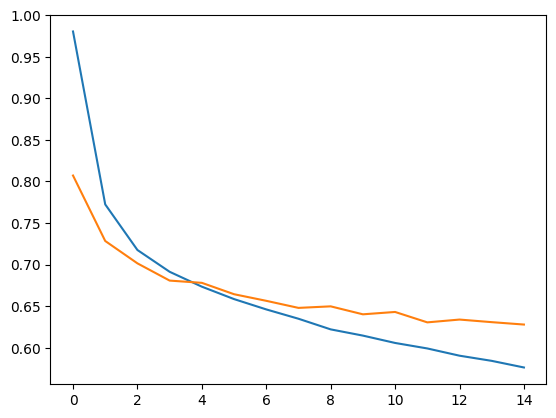

In [62]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [63]:
%%time
from tqdm import tqdm
from transformers import pipeline, TextClassificationPipeline

print("Getting Test Prediction")
pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
prediction = []

for x in tqdm(pipe(data['test']['text'])):
  prediction.append(model.config.label2id[x['label']])

actual_labels = data['test']['labels']

Getting Test Prediction


100%|██████████| 8310/8310 [00:00<00:00, 389890.67it/s]

CPU times: user 14min 35s, sys: 6.55 s, total: 14min 41s
Wall time: 14min 33s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [64]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.14281054159168488
Precision-Score 0.0932049304840557
Recall-Score 0.305294825511432
accuracy_Score 0.305294825511432


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Plotting Confusion Matrix**

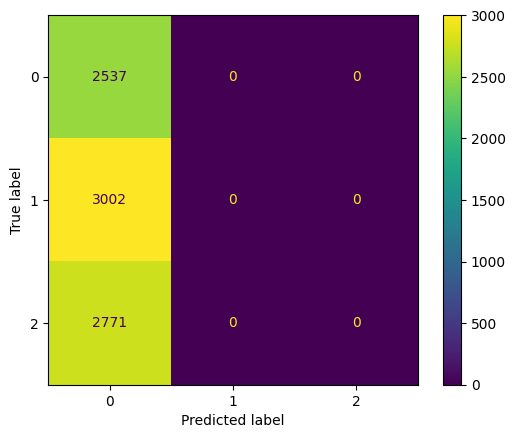

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [66]:
### Pushing Model to hub
# if using=='gpt':
#   model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L4H:Batch 1:Epoch 20; lr=2e-6")


In [67]:
# model.save_pretrained("pretrained_distilgpt2_NepCovid19Tweets_SA")